In [37]:
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, precision_recall_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
import shap
import seaborn as sns


In [2]:
df = pd.read_csv('../Dataset/tic_training_data.csv')
df_test = pd.read_csv('../Dataset/tic_test_data.csv')


In [3]:
df.head()

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,CARAVAN
0,33,1,3,2,8,0,5,1,3,7,...,0,0,0,1,0,0,0,0,0,0
1,37,1,2,2,8,1,4,1,4,6,...,0,0,0,1,0,0,0,0,0,0
2,37,1,2,2,8,0,4,2,4,3,...,0,0,0,1,0,0,0,0,0,0
3,9,1,3,3,3,2,3,2,4,5,...,0,0,0,1,0,0,0,0,0,0
4,40,1,4,2,10,1,4,1,4,7,...,0,0,0,1,0,0,0,0,0,0


In [4]:
df.shape

(5822, 86)

- No existen datos faltantes en el dataset de entrenamiento, por lo que no es necesario realizar imputación.
- El dataset contiene 86 variables, de las cuales 85 son características y una es la variable objetivo.
- No hay variables categóricas, todas las variables son numéricas.
- La variable objetivo "CARAVAN" es binaria (0 y 1), lo que indica si un cliente ha realizado una compra (1) o no (0).
- Hay un desbalance de clases, ya que la gra mayoría de los clientes no realizan compras (0) y una minoría sí (1).

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 86 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   MOSTYPE   5822 non-null   int64
 1   MAANTHUI  5822 non-null   int64
 2   MGEMOMV   5822 non-null   int64
 3   MGEMLEEF  5822 non-null   int64
 4   MOSHOOFD  5822 non-null   int64
 5   MGODRK    5822 non-null   int64
 6   MGODPR    5822 non-null   int64
 7   MGODOV    5822 non-null   int64
 8   MGODGE    5822 non-null   int64
 9   MRELGE    5822 non-null   int64
 10  MRELSA    5822 non-null   int64
 11  MRELOV    5822 non-null   int64
 12  MFALLEEN  5822 non-null   int64
 13  MFGEKIND  5822 non-null   int64
 14  MFWEKIND  5822 non-null   int64
 15  MOPLHOOG  5822 non-null   int64
 16  MOPLMIDD  5822 non-null   int64
 17  MOPLLAAG  5822 non-null   int64
 18  MBERHOOG  5822 non-null   int64
 19  MBERZELF  5822 non-null   int64
 20  MBERBOER  5822 non-null   int64
 21  MBERMIDD  5822 non-null   int64
 22  

In [6]:
# Balance de clases
print("Balance de clases:")
print(df['CARAVAN'].value_counts(normalize=True) * 100)

Balance de clases:
CARAVAN
0    94.022673
1     5.977327
Name: proportion, dtype: float64


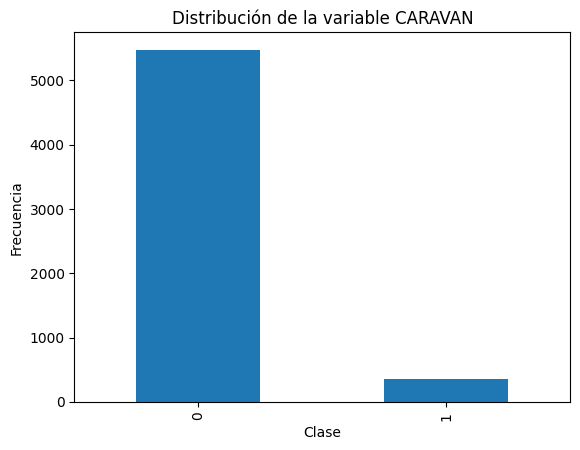

In [7]:

# Histograma de la variable objetivo
df['CARAVAN'].value_counts().plot(kind='bar')
plt.title('Distribución de la variable CARAVAN')
plt.xlabel('Clase')
plt.ylabel('Frecuencia')
plt.show()

- Los valores unicos de las variables son en su mayoría bajos, lo que indica que muchas variables tienen pocos valores únicos.
- Una variable tiene un porcentaje alto de valores únicos, lo que podría indicar que es una variable categórica codificada.
- No hay valores vacios en el dataset, lo que es positivo para el análisis y modelado.


In [8]:
porcentaje_unicos = df.nunique()/len(df) * 100
porcentaje_unicos = porcentaje_unicos.sort_values(ascending=False)
porcentaje_unicos

MOSTYPE     0.687049
MGODRK      0.171762
MOSHOOFD    0.171762
MRELGE      0.171762
MGODGE      0.171762
              ...   
PFIETS      0.034352
AGEZONG     0.034352
APERSONG    0.034352
AZEILPL     0.034352
CARAVAN     0.034352
Length: 86, dtype: float64

In [9]:
porcentaje_vacios = df.isna().sum()/len(df)
porcentaje_vacios = porcentaje_vacios.sort_values(ascending=False)
porcentaje_vacios

MOSTYPE     0.0
MAANTHUI    0.0
MGEMOMV     0.0
MGEMLEEF    0.0
MOSHOOFD    0.0
           ... 
APLEZIER    0.0
AFIETS      0.0
AINBOED     0.0
ABYSTAND    0.0
CARAVAN     0.0
Length: 86, dtype: float64

In [10]:
print(df.shape)
df.drop_duplicates(keep="first", inplace=True)
print(df.shape)

(5822, 86)
(5220, 86)


- Se realizará una reducción de dimensionalidad para eliminar variables altamente correlacionadas, ya que esto puede mejorar el rendimiento del modelo y reducir el sobreajuste.

In [11]:

# Paso 1: Correlación con la variable objetivo
cor_target = df.corr()['CARAVAN'].drop('CARAVAN').abs()

# Paso 2: Encuentra pares altamente correlacionados (>0.7)
corr_matrix = df.drop('CARAVAN', axis=1).corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = set()

for col in upper.columns:
    for row in upper.index:
        if upper.loc[row, col] > 0.7:
            # Paso 3: Compara correlación con la variable objetivo
            if cor_target[row] < cor_target[col]:
                to_drop.add(row)
            else:
                to_drop.add(col)

print(f"Variables a eliminar por alta colinealidad: {to_drop}")

Variables a eliminar por alta colinealidad: {'PPLEZIER', 'AWERKT', 'MHKOOP', 'MOPLMIDD', 'MZPART', 'PZEILPL', 'PTRACTOR', 'AAANHANG', 'MGODPR', 'MAUT1', 'AWALAND', 'AGEZONG', 'PBROM', 'PBESAUT', 'PLEVEN', 'MFWEKIND', 'APERSONG', 'AWABEDR', 'AWAOREG', 'AVRAAUT', 'MOSHOOFD', 'PINBOED', 'AWAPART', 'MFALLEEN', 'PMOTSCO', 'APERSAUT', 'MRELOV', 'PBYSTAND', 'ABRAND', 'PFIETS'}


- Se eliminaran las variables altamente correlacionadas y que no tienen alta correlación con la variable objetivo.

In [12]:
df_train_reduced = df.drop(columns=list(to_drop))
df_train_reduced

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MGODRK,MGODOV,MGODGE,MRELGE,MRELSA,MFGEKIND,...,AMOTSCO,ATRACTOR,ABROM,ALEVEN,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,CARAVAN
0,33,1,3,2,0,1,3,7,0,2,...,0,0,0,0,0,0,0,0,0,0
1,37,1,2,2,1,1,4,6,2,4,...,0,0,0,0,0,0,0,0,0,0
2,37,1,2,2,0,2,4,3,2,4,...,0,0,0,0,0,0,0,0,0,0
3,9,1,3,3,2,2,4,5,2,3,...,0,0,0,0,0,0,0,0,0,0
4,40,1,4,2,1,1,4,7,1,4,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5816,3,1,2,3,0,0,3,6,0,7,...,0,0,0,0,0,0,0,0,0,0
5817,36,1,1,2,0,1,2,1,2,3,...,1,0,0,2,0,0,0,0,0,0
5818,35,1,4,4,1,1,4,6,0,2,...,0,0,1,0,0,0,0,0,0,0
5819,33,1,3,4,0,0,3,5,1,3,...,0,0,0,0,0,0,0,0,0,1


In [13]:
df_train_reduced.shape

(5220, 56)

No se realizan codificaciones ni escalados porque las caracteristicas ya estan codificadas y el modelo soporta los valores sin escalar. Se probó escalando pero el modelo no generaliza mejor.

In [14]:
# Dividir el dataset en entrenamiento y validación
X = df_train_reduced.drop('CARAVAN', axis=1)
y = df_train_reduced['CARAVAN']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # stratify ayuda con clases desequilibradas
print(X_train.shape)
print(X_val.shape)

(4176, 55)
(1044, 55)


- El balanceo de clases es importante en este caso porque la variable objetivo "CARAVAN" está desbalanceada, lo que significa que hay muchas más instancias de la clase 0 (no compra) que de la clase 1 (compra). Esto puede llevar a que el modelo se sesgue hacia la clase mayoritaria y no aprenda adecuadamente a identificar la clase minoritaria.
- Sin embargo, el balanceo de clases puede introducir ruido y afectar la generalización del modelo si no se hace correctamente. Por lo tanto, es importante elegir una técnica de balanceo adecuada y evaluar su impacto en el rendimiento del modelo.
- En este caso tras probar varias técnicas como SMOTE, RandomOverSampler, RandomUnderSampler y SMOTEENN con ninguna ni con la combinación de varias ellas se obtuvo un mejor rendimiento en el modelo.

In [15]:
# Balanceo de clases
smote_enn = SMOTEENN(random_state=42)
X_train_bal, y_train_bal = smote_enn.fit_resample(X_train, y_train)
print("Distribución tras SMOTEENN:", y_train_bal.value_counts())


Distribución tras SMOTEENN: CARAVAN
1    3659
0    2816
Name: count, dtype: int64


Scale Pos Weight para XGBoost nos permite ajustar el peso de las clases desbalanceadas.

In [16]:
scale_pos_weight_value = (y == 0).sum() / (y == 1).sum()
print(f"Scale Pos Weight calculado: {scale_pos_weight_value}")

Scale Pos Weight calculado: 14.352941176470589


Ahora se procede a entrenar el modelo XGBoost con los hiperparámetros óptimos utilizando GridSearchCV para encontrar la mejor combinación de hiperparámetros.

In [17]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.001, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Modelo base
xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    scale_pos_weight=scale_pos_weight_value
)

# GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=2
)
grid_search.fit(X_train, y_train)

# Modelo final con mejores hiperparámetros
mejor_modelo = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    scale_pos_weight=scale_pos_weight_value,
    **grid_search.best_params_
)
mejor_modelo.fit(X_train, y_train)

print("Mejores hiperparámetros:", grid_search.best_params_)
print("Mejor score AUC de entrenamiento:", grid_search.best_score_)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Mejores hiperparámetros: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}
Mejor score AUC de entrenamiento: 0.7675658806364715


Procedemos a evaluar el modelo en el set de validación para ver su rendimiento antes de probarlo en el set de test. Y se muestra el reporte de clasificación y la matriz de confusión.

In [18]:
# Evalúa en el set de validación
y_val_pred = mejor_modelo.predict(X_val)
y_val_proba = mejor_modelo.predict_proba(X_val)[:, 1]

print(classification_report(y_val, y_val_pred))
print("AUC ROC de validación:", roc_auc_score(y_val, y_val_proba))

              precision    recall  f1-score   support

           0       0.97      0.74      0.84       976
           1       0.15      0.66      0.24        68

    accuracy                           0.73      1044
   macro avg       0.56      0.70      0.54      1044
weighted avg       0.92      0.73      0.80      1044

AUC ROC de validación: 0.7832690453230472


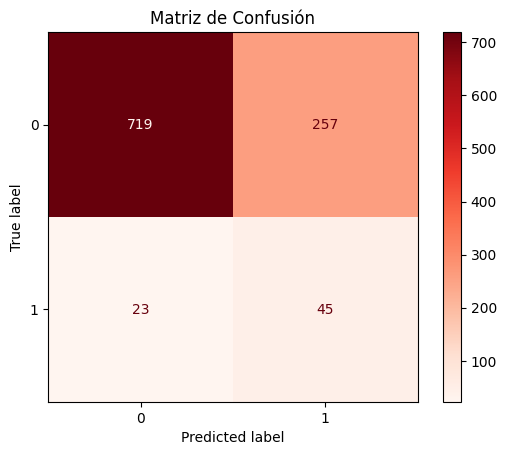

In [19]:
cm = confusion_matrix(y_val, y_val_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Reds)
plt.title('Matriz de Confusión')
plt.show()

Ahora se procede a evaluar el modelo en el set de test para ver su rendimiento final. Se carga el set de test y se realiza la misma reducción de dimensionalidad que se hizo en el set de entrenamiento.

In [20]:
y_test_real = pd.read_csv('../Dataset/tictgts2000.txt', header=None)
df_test['CARAVAN'] = y_test_real
df_test.head()

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,CARAVAN
0,33,1,4,2,8,0,6,0,3,5,...,0,0,0,1,0,0,0,0,0,0
1,6,1,3,2,2,0,5,0,4,5,...,0,0,0,1,0,0,0,0,0,1
2,39,1,3,3,9,1,4,2,3,5,...,0,0,0,1,0,0,0,0,0,0
3,9,1,2,3,3,2,3,2,4,5,...,0,0,0,1,0,0,0,0,0,0
4,31,1,2,4,7,0,2,0,7,9,...,0,0,0,1,0,0,0,0,0,0


In [21]:
df_test_reduced = df_test.drop(columns=list(to_drop))
df_train_reduced.shape

(5220, 56)

In [22]:
X_test = df_test_reduced.drop(columns=['CARAVAN'])
y_test = df_test_reduced['CARAVAN']

In [23]:
# Evaluar con métricas detalladas en test
y_test_pred = mejor_modelo.predict(X_test)
y_test_proba = mejor_modelo.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_test_pred))
print("AUC ROC:", roc_auc_score(y_test, y_test_proba))

              precision    recall  f1-score   support

           0       0.97      0.75      0.84      3762
           1       0.13      0.60      0.21       238

    accuracy                           0.74      4000
   macro avg       0.55      0.67      0.53      4000
weighted avg       0.92      0.74      0.80      4000

AUC ROC: 0.731314694936986


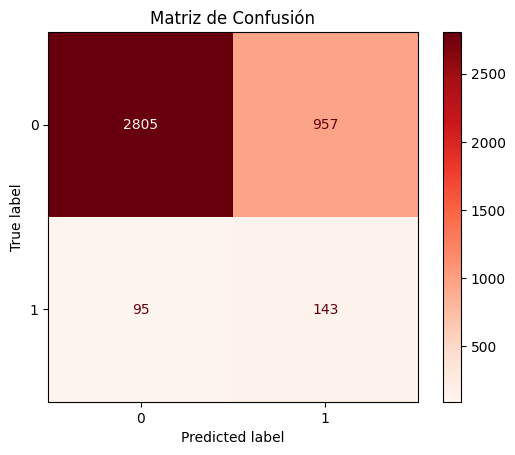

In [24]:
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_test_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Reds)
plt.title('Matriz de Confusión')
plt.show()

     feature  importance
37  PPERSAUT    0.085796
32   MINKGEM    0.034062
44    PBRAND    0.031106
27   MINKM30    0.030335
11  MOPLLAAG    0.028797
7     MRELGE    0.028073
15  MBERMIDD    0.024594
33  MKOOPKLA    0.023786
22      MSKD    0.023164
25     MAUT0    0.023098
51  APLEZIER    0.022836
48     ABROM    0.021637
36   PWALAND    0.021020
14  MBERBOER    0.020859
34   PWAPART    0.020509
12  MBERHOOG    0.020428
26   MZFONDS    0.020343
1   MAANTHUI    0.019990
0    MOSTYPE    0.019884
29  MINK4575    0.019822


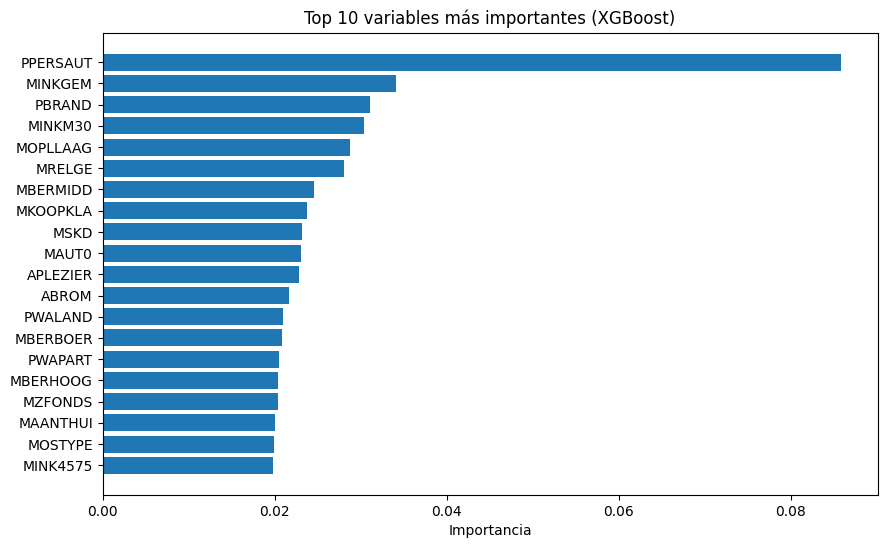

In [25]:
# Obtener importancias
importancias = mejor_modelo.feature_importances_
nombres = X_train.columns

# Crear DataFrame ordenado
df_importancias = pd.DataFrame({'feature': nombres, 'importance': importancias})
df_importancias = df_importancias.sort_values(by='importance', ascending=False)

# Mostrar las 10 más importantes
print(df_importancias.head(20))

# Gráfico de barras
plt.figure(figsize=(10,6))
plt.barh(df_importancias['feature'][:20][::-1], df_importancias['importance'][:20][::-1])
plt.xlabel('Importancia')
plt.title('Top 10 variables más importantes (XGBoost)')
plt.show()

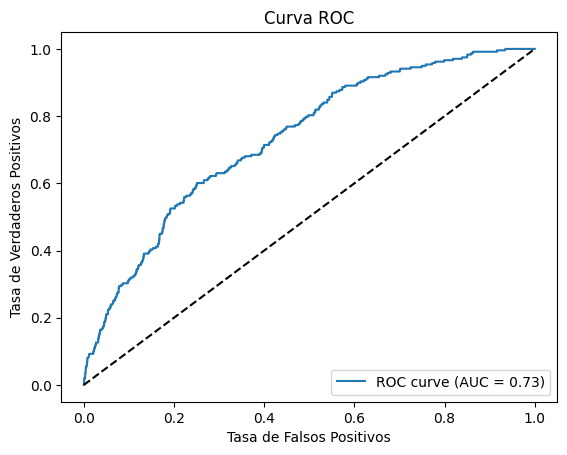

In [26]:
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

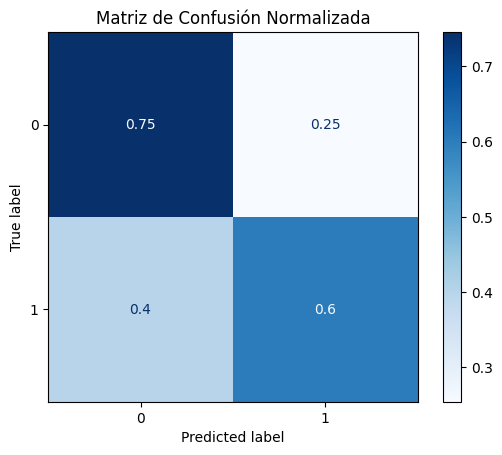

In [27]:
cm_norm = confusion_matrix(y_test, y_test_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusión Normalizada')
plt.show()

In [31]:
# Identificar índices de falsos positivos y falsos negativos
falsos_positivos = (y_test == 0) & (y_test_pred == 1)
falsos_negativos = (y_test == 1) & (y_test_pred == 0)

# Extraer ejemplos problemáticos
ejemplos_fp = X_test[falsos_positivos]
ejemplos_fn = X_test[falsos_negativos]

print("Falsos positivos:", ejemplos_fp.shape[0])
print("Falsos negativos:", ejemplos_fn.shape[0])

# Visualizar algunos ejemplos
print("Ejemplo falso positivo:\n", ejemplos_fp.head())
print("Ejemplo falso negativo:\n", ejemplos_fn.head())

Falsos positivos: 957
Falsos negativos: 95
Ejemplo falso positivo:
     MOSTYPE  MAANTHUI  MGEMOMV  MGEMLEEF  MGODRK  MGODOV  MGODGE  MRELGE  \
2        39         1        3         3       1       2       3       5   
6        35         1        2         4       2       1       2       8   
17       39         2        5         3       0       0       3       9   
20       33         1        2         2       0       2       4       3   
23       39         1        4         2       2       2       2       8   

    MRELSA  MFGEKIND  ...  ABESAUT  AMOTSCO  ATRACTOR  ABROM  ALEVEN  AZEILPL  \
2        2         3  ...        0        0         0      0       1        0   
6        0         5  ...        0        0         0      0       0        0   
17       0         3  ...        0        1         0      0       1        0   
20       2         4  ...        0        0         1      0       0        0   
23       0         3  ...        0        0         0      0       0  

In [34]:
shap.initjs()

# Calcular valores SHAP si no lo has hecho antes
explainer = shap.TreeExplainer(mejor_modelo)
shap_values = explainer.shap_values(X_test)

# Visualizar explicación SHAP de un falso negativo
idx_fn = ejemplos_fn.index[0]
shap.force_plot(explainer.expected_value, shap_values[idx_fn], X_test.loc[idx_fn])

In [35]:
# Visualizar explicación SHAP de un falso positivo
idx_fp = ejemplos_fp.index[0]
shap.force_plot(explainer.expected_value, shap_values[idx_fp], X_test.loc[idx_fn])

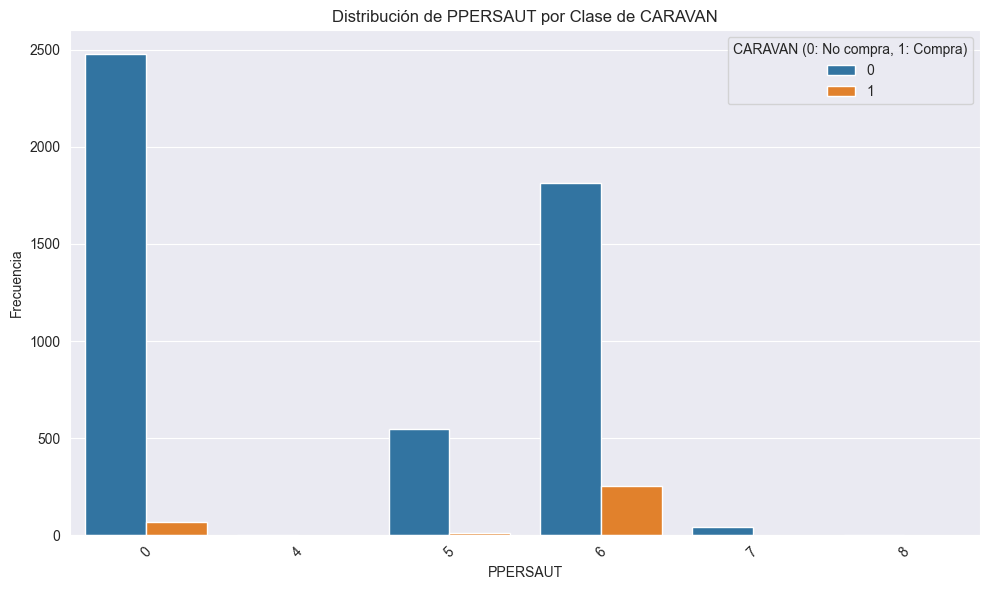

In [44]:
conteo_ppersaut = df.groupby(['CARAVAN', 'PPERSAUT']).size().reset_index(name='count')

plt.figure(figsize=(10, 6))
sns.barplot(x='PPERSAUT', y='count', hue='CARAVAN', data=conteo_ppersaut)
plt.title('Distribución de PPERSAUT por Clase de CARAVAN')
plt.xlabel('PPERSAUT')
plt.ylabel('Frecuencia')
plt.legend(title='CARAVAN (0: No compra, 1: Compra)')
plt.xticks(rotation=45) # Rota las etiquetas del eje x si hay muchos valores
plt.tight_layout() # Ajusta el diseño para evitar solapamientos
plt.show()